### Introduction
This notebook explains the implementation methodology of the UNet model developed, and demonstrates how it can be used for image segmentation tasks as explained in the orginal Unet paper. This work was carried out as part of the Final project for the course `Computer Vision & 3D Reconstruction` at UIB
- Author: Halidu Abdulai
  
Before I dive into the demonstration, I will briefly explain the implementation details of the UNet model, and any other information deemed necessary in this section.
### How the UNet was implemented (very similar to the original paper's implementations with few modifications):
The Unet model was implemented by using a modularity approach where each component (Encoder, Decoder, Block) is defined independently, thus promoting reuseabilty (though not necessary, but you know, this is the standard these days 😉). The implementation consists of the following modules:
- Block Subclass: The `Block` subclass implements a sequence of operations: `Conv2d` → `BatchNorm2d` → `ReLU`. It is used as the building block for both the encoder and decoder layers and operates with kernel size 3 and user-defined padding (default  is same padding).
- Encoder Subclass: The `Encoder` subclass uses a series of Block instances for hierarchical feature extraction (which follows the exact original implementation).It includes MaxPool2d for downsampling and a Dropout2d layer (0.2 dropout rate) for regularization. It outputs a list of feature maps (ftrs).
- Decoder Subclass: The `Decoder` subclass employs ConvTranspose2d layers for upsampling. The reason for using the `ConvTranspose2D` layers is that unlike fixed interpolation methods (e.g., bilinear or nearest neighbor), ConvTranspose2d introduces `learnable parameters`, enabling the model to optimize the upsampling process for the task-specific requirements. In the decoder subclass, encoder features are cropped (using CenterCrop) to match dimensions of the upsampled features. It then concatenates cropped encoder features with upsampled features for skip connections. Additional Block instances are used to refine concatenated features.
- A Final Layer (Head): The Final layer consists of a  single Conv2d layer which reduces the number of channels to the target classes (num_class).
- It is important to point out that drop-out layers are only added in the encoder but not in the decoder. Additionally, BatchNorm layers are included to helps stabilize and accelerate training.

For full review on the code, please refer to the `model.py`(`project_dir/models/model.py`) file

### Dataset and Data augumentation techniques employed: 
The original dataset for the UNet paper from the`The ISBI 2012 challenge, titled "Segmentation of Neuronal Structures in EM Stacks,"` which  focuses on developing algorithms to automatically segment neuronal structures from serial section Transmission Electron Microscopy (ssTEM) images was used in this work. Perhaps, the most interesting part of building the dataclass was the data augmentation techniques. As mentioned in the Unet paper, `elastic deformation` techniques were employed. Elastic deformation introduces random, smooth, and spatially varying distortions to an image by applying a displacement field. This is often achieved using random displacement vectors smoothed with a Gaussian filter (as explained in the UNet paper). In addition to this, Rigid transformations such as (horizontal/vertical) flipping , rotating, and cropping were implemented. These were only applied as online data augumentation (i.e., performed dynamically during training) without (necessarily) increasing the size of the available dataset (of 30 samples). The augumentation techniques used hence include:
- Elastic deformations
- RandomHorizontalFlip/RandomVerticalFlip
- RandomResizedCrop

Below is a code snippet demonstrating how this was implemented.
```python
def elastic_deformation(image, mask=None, sigma=10, points=3):
    """
    Apply elastic deformation to an image (and optional mask).

    Parameters:
        image (PIL Image or np.ndarray): The input image.
        mask (PIL Image or np.ndarray, optional): The corresponding mask.
        sigma (float): Standard deviation of the Gaussian distribution for displacement.
        points (int): Number of control points for the coarse grid.

    Returns:
        Deformed image (and mask if provided).
    """
    # Convert PIL images to numpy arrays if necessary
    if isinstance(image, Image.Image):
        image = np.array(image)
    if mask is not None and isinstance(mask, Image.Image):
        mask = np.array(mask)

    # Prepare the input for elasticdeform
    inputs = [image]
    if mask is not None:
        inputs.append(mask)

    # Apply elastic deformation
    deformed = etorch.deform_random_grid(inputs, sigma=sigma, points=points, order=[3, 0])

    # Convert back to PIL images
    deformed_image = Image.fromarray(deformed[0])
    if mask is not None:
        deformed_mask = Image.fromarray(deformed[1]) 
        return deformed_image, deformed_mask
    return deformed_image 

class DualTransform:
    """Applies the same transform to both image and label."""
    def __init__(self, transforms, apply_elastic=False, elastic_params=None):
        self.transforms = transforms
        self.apply_elastic = apply_elastic 
        self.elastic_params = elastic_params if elastic_params else {'sigma': 10, 'points': 3}

    def __call__(self, image, label=None):
        if image is None:
            raise ValueError("Image cannot be None.")

        # Apply elastic deformation if specified
        if self.apply_elastic:
            image, label = elastic_deformation(image, label, **self.elastic_params)

        # Apply other transformations
        for transform in self.transforms:
            if isinstance(transform, (RandomHorizontalFlip, RandomVerticalFlip)) and random.random() < transform.p:
                flip_func = F.hflip if isinstance(transform, RandomHorizontalFlip) else F.vflip
                image = flip_func(image)
                if label:
                    label = flip_func(label)
            elif isinstance(transform, RandomResizedCrop):
                i, j, h, w = transform.get_params(image, transform.scale, transform.ratio)
                image = F.resized_crop(image, i, j, h, w, transform.size, transform.interpolation)
                if label:
                    label = F.resized_crop(label, i, j, h, w, transform.size, F.InterpolationMode.NEAREST)
            elif isinstance(transform, ToTensor):
                image = F.to_tensor(image)
                if label:
                    label = F.to_tensor(label)
            elif isinstance(transform, Normalize):
                image = F.normalize(image, transform.mean, transform.std)

        return image, label 
```
The full dataclass implementation code can be reviewed at`project_dir/data/dataset.py`

#### Model Training & Optimization algorithm
To follow 'modern' way of coding (well, you could call it best coding practices), the training code was organized into a seprate file. Perhaps the only thing different from any standard deep learning code is the loss function. A custom lost function which evaluates the model based on Binary Cross Enthropy and DICE coefficient was implemented. 

In image segmentation tasks, combining Binary Cross-Entropy (BCE) and Dice loss functions is a common strategy to leverage the strengths of both. BCE loss is effective for pixel-wise classification and provides well-behaved gradients, facilitating stable training. However, it may struggle with class imbalance, as it treats each pixel independently and doesn't account for the overlap between predicted and actual segments. Dice loss, on the other hand, directly measures the overlap between predicted and ground truth segments, making it particularly useful for handling class imbalance by focusing on the overall segmentation structure. Source: [Stackexchange](https://stats.stackexchange.com/questions/321460/dice-coefficient-loss-function-vs-cross-entropy)

The implementation is as shown below.
```python
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce_criterion = nn.BCEWithLogitsLoss()
        
    def forward(self, inputs, targets):
        bce_loss = self.bce_criterion(inputs, targets)
        
        # Dice loss
        inputs_sigmoid = torch.sigmoid(inputs)
        intersection = (inputs_sigmoid * targets).sum()
        dice_loss = 1 - (2. * intersection + 1e-7) / (
            inputs_sigmoid.sum() + targets.sum() + 1e-7
        )
        
        # Combined loss
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss
```
The model was then evaluated based on the this custom loss function. 

Additionally, The `Adam` optimizer was used. This is in contrast to the SGD optimizer used in the original UNet paper. This decision was based on the fact that Adam optimizer automatically adjusts learning rates for each parameter using adaptive moment estimation, leading to faster convergence and reduced need for manual tuning. It also incorporates momentum, reducing oscillations and handling noisy gradients better. Unlike SGD, which requires learning rate scheduling, Adam dynamically adapts, making it more efficient for mini-batch training. Below is the code snippet of the optimizer
```python
def get_optimizer(self, model):
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=self.config.get('learning_rate', 1e-4),
            betas=(self.config.get('beta1', 0.9), self.config.get('beta2', 0.999)),
            eps=self.config.get('eps', 1e-8),
            weight_decay=self.config.get('weight_decay', 1e-4)
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=5
        )
        return optimizer, scheduler
```

The full code can be reviewed at `project_dir/models/train_utils.py`

I know, this part was very boring so let's jump straight to the demonstration. 


## Table-of-content:
- [Introduction](#Introduction)
- [Part A: Neuronal cells segmentation](#Part-A:)
    - [Checking samples from the dataset](#Dataset-Samples)
    - [Configuration settings](#Configurations)
    - [Initializing the Trainer](#Trainer-Initializing)
    - [Dataloaders](#DataLoaders)
    - [Model Training](#Training)
    - [Training Metrics Visualization](#Training-Metrics-Visualization)
    - [Model Evaluation on test samples](#Model-Evaluation)
    - [Predicted Test Samples Visualization](#Predicted-Test-Samples-Visualization)
- [Part B: extra work (brain tumor segmentation)](#Part-B:)
    - [Brain Tumor DataLoaders](#Brain-Tumor-Data-Loaders)
    - [Brain Tumor data samples visualization](#Visualize-data-samples-from-the-training-set)
    - [Brain Tumor trainer initialization & Training](#Initialize-Brain-Tumor-Trainer-and-Train-model)
    - [Model Performance Evaluation](#Brain-Tumor-Model-Performance-Evaluation)
- [Conclusion](#Conclusion)

## Part A: 
### Neuronal Cells Segmentation (original dataset used in the UNet paper)
### Notebook Imports

In [40]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import (Compose, ToPILImage, RandomHorizontalFlip, RandomVerticalFlip,
                                    RandomResizedCrop, ToTensor, Normalize)
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import sys
import random
import cv2
from pathlib import Path

# Get the absolute path of the project root directory
project_root = os.path.abspath("..")

# Add the project root to the Python module search path
if project_root not in sys.path:
    sys.path.append(project_root)

from data.dataset import CellDataset, DualTransform
from models.model import UNet
from models.train_utils import Trainer

[Go to the table of content](#Table-of-content:)
#### Dataset Samples
Let's begin by exploring the dataset to understand its structure. The same dataset used in the original UNet implementation is adopted here. 

Here is a brief description of the dataset:<br>
`The ISBI 2012 challenge, titled "Segmentation of Neuronal Structures in EM Stacks," focuses on developing algorithms to automatically segment neuronal structures from serial section Transmission Electron Microscopy (ssTEM) images. Participants are provided with a stack of EM slices from the Drosophila first instar larva ventral nerve cord and are tasked with creating machine learning models that accurately distinguish neural structures within these images. The challenge evaluates methods based on pixel and object classification accuracy, aiming to advance techniques in biomedical image segmentation`

Let's first visualize a few samples of the dataset 

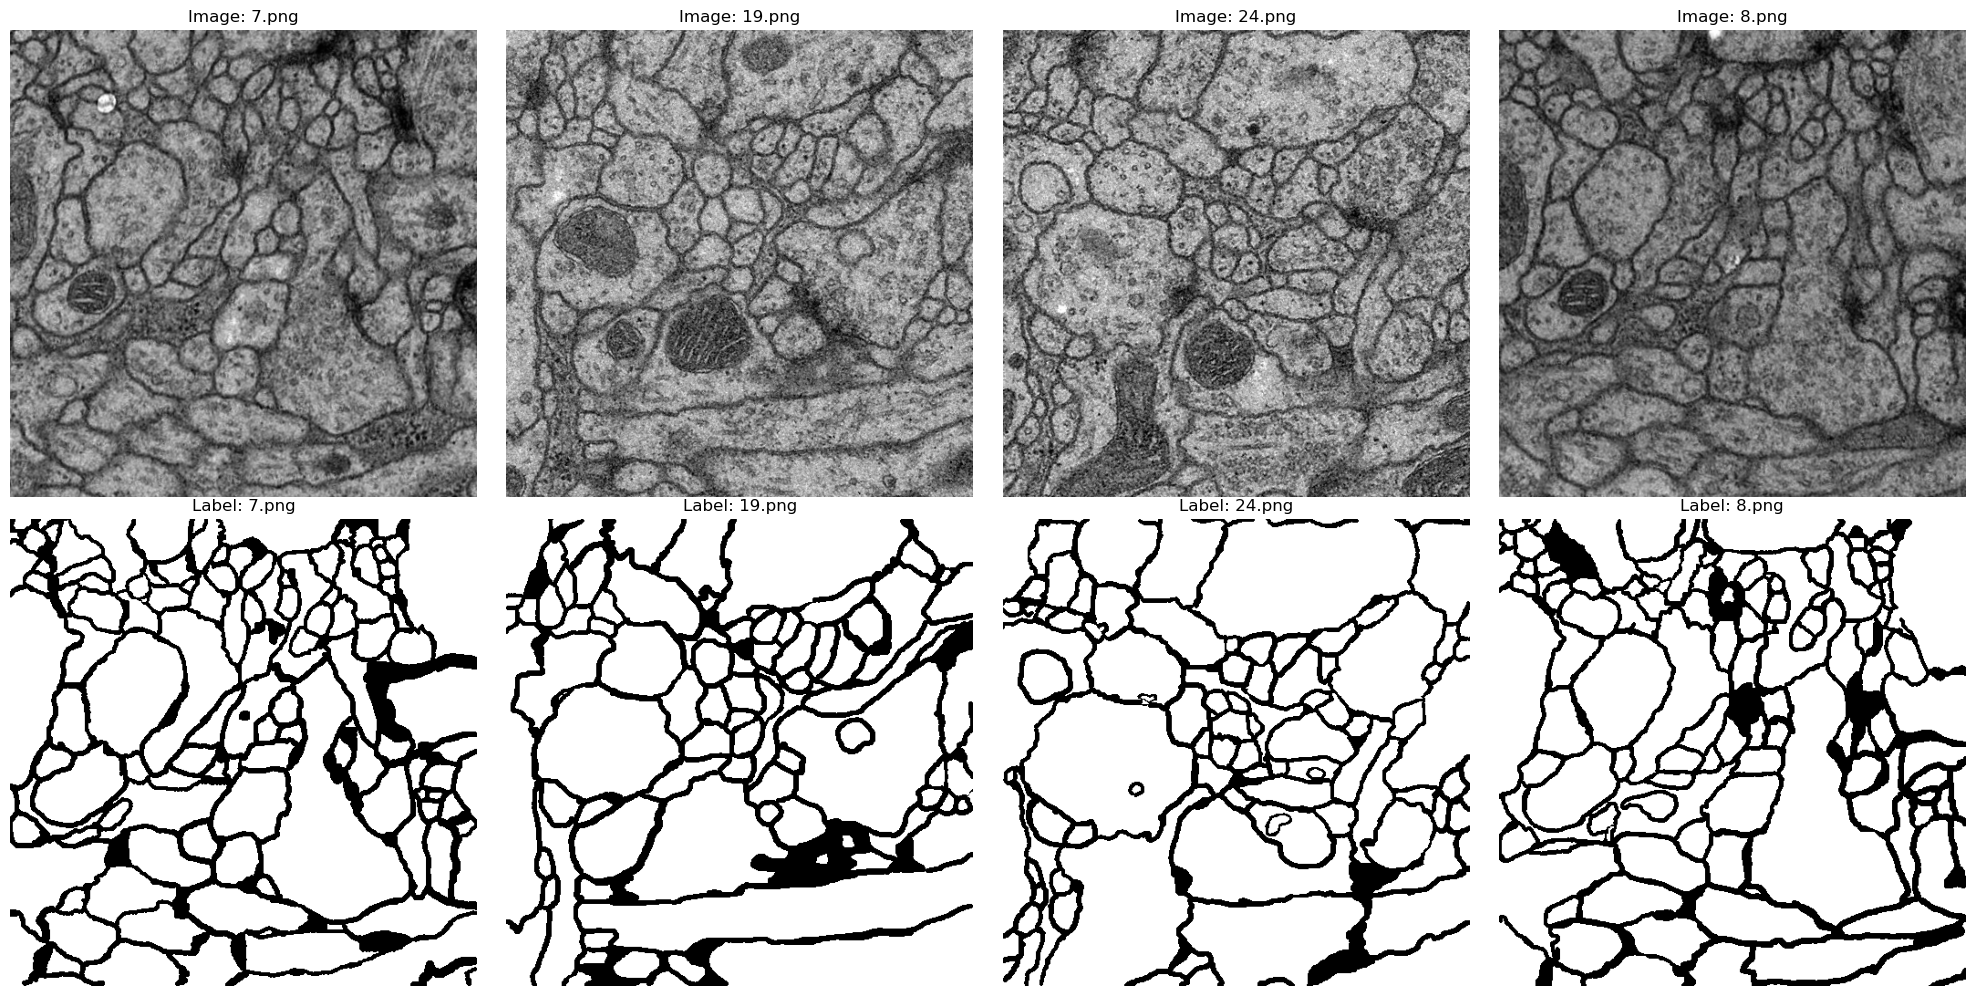

In [25]:
# Directories for images and labels
img_dir = os.path.join("../data", "dataset", 'train', 'imgs')
lab_dir = os.path.join("../data", "dataset", 'train', 'labels')

def visualize_data_samples(img_dir=img_dir, lab_dir=lab_dir):
    # Get filenames of images
    img_fns = os.listdir(img_dir)
    # Create a grid for 4 images and their labels (2 rows, 4 columns)
    f, axarr = plt.subplots(2, 4, figsize=(20, 10))
    
    # Randomly sample 4 indices
    indices = random.sample(range(len(img_fns)), 4)
    
    for i, index in enumerate(indices):
        # Get the corresponding image and label filenames
        img_fn = img_fns[index]
        lab_fn = img_fn  # The label has the same name as the image
    
        # Construct full paths to the image and label files
        img_path = os.path.join(img_dir, img_fn)
        label_path = os.path.join(lab_dir, lab_fn)

        # Read the image and label
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    
        # Display the image
        axarr[0, i].imshow(img, cmap="gray")
        axarr[0, i].axis('off')
        axarr[0, i].set_title(f"Image: {img_fn}")
    
        # Display the corresponding label
        axarr[1, i].imshow(label, cmap="gray")
        axarr[1, i].axis('off')
        axarr[1, i].set_title(f"Label: {lab_fn}")
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
visualize_data_samples(img_dir, lab_dir)

The samples above are randomly selected from the training set, which consist of both the images and their (true labels) masks. There are 30 samples in total, for which:
- 25 samples are used for training
- 5 samples are manually selected for validation. The manuall selection was necessary to ensure variety (some of the samples are very similar to each other in terms of shape)

### Configurations
A `Trainer` class was implemented with the necessary methods to carry out the training process. As part of its modularity approach, the trainer class takes a config object with all the necessary parameters specified.<br>
These parameters are passed to the the trainer for initialization including initializing the UNet model.<br>
Most of the parameters specified below are the default values in the implementation but are repeated here for clarity sake. For the full implementation details of the Trainer class, refer to the file `project_dir/models/train_utils.py`

In [10]:
# Define configuration
config = {
    # Model parameters
    'out_size': (512, 512),
    
    # Training parameters
    'batch_size': 1,
    'learning_rate': 1e-4,
    'beta1': 0.9,
    'beta2': 0.999,
    'eps': 1e-8,
    'weight_decay': 1e-4,
    'start_epoch': 1,
    'end_epoch': 21,
    
    # Loss function weights
    'bce_weight': 0.7,
    'dice_weight': 0.3
}

### Trainer Initializing
We proceed to initialize a trainer object which takes the config object and sets up the model and training process. We also define the transformations for the dataset augmentation.

Please note that out of the 30 training dataset, 25 are used to train the model, and 5 are used for validation.

[Click here to go back to the table of content](#Table-of-content:)

In [11]:
# Initialize the trainer
trainer = Trainer(config)

train_dataset_path = os.path.join("../data", "dataset", 'train')
# Compute dataset statistics. We need the mean and std of the training data to normalize the dataset
mean, std = trainer.compute_statistics(dataset_path=train_dataset_path)

# Training transformations (data augumentation techniques)
train_transform = DualTransform(
    transforms=[
        ToPILImage(),
        RandomHorizontalFlip(0.5),
        RandomVerticalFlip(0.5),
        RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0)),
        ToTensor(),
        Normalize(mean=[mean], std=[std])
    ],
    apply_elastic=True, # Further elastic transformations are applied. Check the introduction section above for details
    elastic_params={'sigma': 10, 'points': 3} # These params are from the UNet Paper
)
# No transformation is applied to the validation set. We just convert it to Tensor format and normalize it
val_transform = DualTransform([
    ToTensor(),
    Normalize(mean=[mean], std=[std])
])

### DataLoaders
The dataset was manually splitted into 25 samples for training and 5 samples for validation.<br>
We load the dataset using the custom dataclass `CellDataset`. The dataclass load the data, applies augumentation during training. Check the file `project_dir/data/dataset.py` for full implementation details

In [12]:
# Create datasets
train_dataset = CellDataset(
    root_dir="../data/dataset", 
    split="train", 
    transform=train_transform
)

val_dataset = CellDataset(
    root_dir="../data/dataset", 
    split="val", 
    transform=val_transform
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=0,  
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

### Training
Here we just have to call the trainer.train method and pass the train and validation dataloaders as parameters and the model will be trained with detailed logging. As can seen below, the best validation loss obtained at the end of the training is also printed.

In [13]:
# Start training
model, best_val_loss = trainer.train(train_loader, val_loader)
print(f"Best validation loss: {best_val_loss:.4f}")

Epoch 1 (val): 100%|███████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.501, acc=77.9, dice=0.867]


Epoch 001: Train Loss=1.1598 [Train Acc=66.78%] [Train Dice=0.74] | Val Loss=0.5012 [Val Acc=77.91%] [Val Dice=0.87]


Epoch 2 (val): 100%|███████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.386, acc=83.6, dice=0.897]


Epoch 002: Train Loss=0.4264 [Train Acc=80.01%] [Train Dice=0.87] | Val Loss=0.3857 [Val Acc=83.63%] [Val Dice=0.90]


Epoch 3 (val): 100%|███████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.311, acc=83.6, dice=0.891]


Epoch 003: Train Loss=0.2923 [Train Acc=84.06%] [Train Dice=0.89] | Val Loss=0.3111 [Val Acc=83.59%] [Val Dice=0.89]


Epoch 4 (val): 100%|███████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.286, acc=86.1, dice=0.912]


Epoch 004: Train Loss=0.2691 [Train Acc=84.95%] [Train Dice=0.90] | Val Loss=0.2862 [Val Acc=86.07%] [Val Dice=0.91]


Epoch 5 (val): 100%|███████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.449, acc=84.1, dice=0.906]


Epoch 005: Train Loss=0.2518 [Train Acc=85.73%] [Train Dice=0.91] | Val Loss=0.4490 [Val Acc=84.10%] [Val Dice=0.91]


Epoch 6 (val): 100%|████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.25, acc=86.4, dice=0.912]


Epoch 006: Train Loss=0.2435 [Train Acc=86.21%] [Train Dice=0.91] | Val Loss=0.2498 [Val Acc=86.37%] [Val Dice=0.91]


Epoch 7 (val): 100%|███████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.243, acc=87.6, dice=0.921]


Epoch 007: Train Loss=0.2324 [Train Acc=86.85%] [Train Dice=0.91] | Val Loss=0.2427 [Val Acc=87.57%] [Val Dice=0.92]


Epoch 8 (val): 100%|███████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.237, acc=87.3, dice=0.916]


Epoch 008: Train Loss=0.2254 [Train Acc=87.34%] [Train Dice=0.92] | Val Loss=0.2368 [Val Acc=87.31%] [Val Dice=0.92]


Epoch 9 (val): 100%|█████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.215, acc=88, dice=0.922]


Epoch 009: Train Loss=0.2203 [Train Acc=87.82%] [Train Dice=0.92] | Val Loss=0.2145 [Val Acc=88.02%] [Val Dice=0.92]


Epoch 10 (val): 100%|██████████████████████████████████| 6/6 [00:00<00:00, 10.30it/s, loss=0.195, acc=89.4, dice=0.932]


Epoch 010: Train Loss=0.2106 [Train Acc=88.21%] [Train Dice=0.92] | Val Loss=0.1951 [Val Acc=89.39%] [Val Dice=0.93]


Epoch 11 (val): 100%|██████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.197, acc=88.5, dice=0.924]


Epoch 011: Train Loss=0.2036 [Train Acc=88.60%] [Train Dice=0.92] | Val Loss=0.1972 [Val Acc=88.53%] [Val Dice=0.92]


Epoch 12 (val): 100%|██████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.226, acc=89.4, dice=0.932]


Epoch 012: Train Loss=0.2003 [Train Acc=88.94%] [Train Dice=0.93] | Val Loss=0.2264 [Val Acc=89.43%] [Val Dice=0.93]


Epoch 13 (val): 100%|████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.185, acc=89, dice=0.927]


Epoch 013: Train Loss=0.1952 [Train Acc=89.15%] [Train Dice=0.93] | Val Loss=0.1852 [Val Acc=88.96%] [Val Dice=0.93]


Epoch 14 (val): 100%|██████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.174, acc=90.5, dice=0.939]


Epoch 014: Train Loss=0.1929 [Train Acc=89.36%] [Train Dice=0.93] | Val Loss=0.1743 [Val Acc=90.53%] [Val Dice=0.94]


Epoch 15 (val): 100%|██████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.173, acc=90.3, dice=0.937]


Epoch 015: Train Loss=0.1909 [Train Acc=89.44%] [Train Dice=0.93] | Val Loss=0.1732 [Val Acc=90.27%] [Val Dice=0.94]


Epoch 16 (val): 100%|██████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.178, acc=90.2, dice=0.937]


Epoch 016: Train Loss=0.1886 [Train Acc=89.64%] [Train Dice=0.93] | Val Loss=0.1776 [Val Acc=90.22%] [Val Dice=0.94]


Epoch 17 (val): 100%|██████████████████████████████████| 6/6 [00:00<00:00, 10.23it/s, loss=0.181, acc=90.1, dice=0.935]


Epoch 017: Train Loss=0.1853 [Train Acc=89.70%] [Train Dice=0.93] | Val Loss=0.1814 [Val Acc=90.08%] [Val Dice=0.94]


Epoch 18 (val): 100%|██████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.198, acc=89.8, dice=0.935]


Epoch 018: Train Loss=0.1833 [Train Acc=89.90%] [Train Dice=0.93] | Val Loss=0.1977 [Val Acc=89.82%] [Val Dice=0.94]


Epoch 19 (val): 100%|███████████████████████████████████| 6/6 [00:00<00:00, 10.22it/s, loss=0.18, acc=89.7, dice=0.933]


Epoch 019: Train Loss=0.1845 [Train Acc=89.72%] [Train Dice=0.93] | Val Loss=0.1803 [Val Acc=89.74%] [Val Dice=0.93]


Epoch 20 (val): 100%|██████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.167, acc=90.5, dice=0.938]


Epoch 020: Train Loss=0.1847 [Train Acc=89.78%] [Train Dice=0.93] | Val Loss=0.1666 [Val Acc=90.48%] [Val Dice=0.94]
Best validation loss: 0.1666


### Training Metrics Visualization
From the training logs in the cell above, it can be observed that the model exhibits a bit of unstableness during training. However, the loss decreases overall.<br>
Let's visualize the metrics

[Go back to table of content](#Table-of-content:)

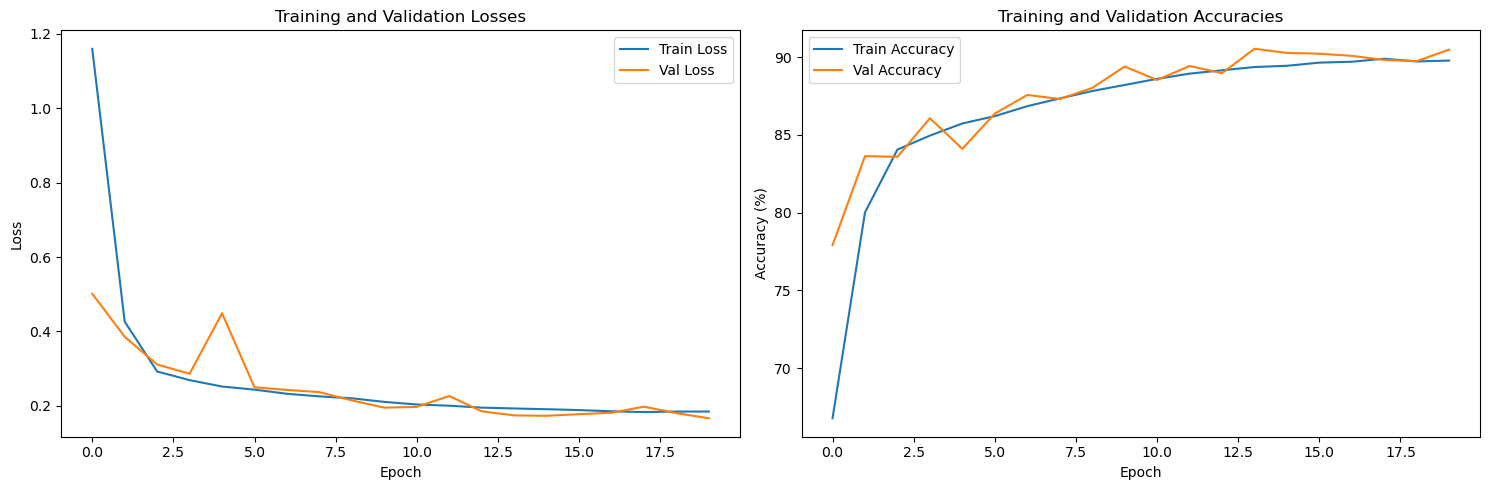

In [14]:
# Plot final metrics
def plot_metrics(trainer):
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label='Train Loss')
    plt.plot(trainer.val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_accuracies, label='Train Accuracy')
    plt.plot(trainer.val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracies')
    
    plt.tight_layout()
    plt.show()
    
# Plot the training metrics
plot_metrics(trainer)

As mentioned above, the model exhibits a bit of unstableness during training. This can be attributed to the fact that there are very few samples for validation. Additionally, a batch size of 1 was used and that could have contributed to the unstableness. Overall, the loss decreases while the accuracy increases. From the training logs in the previous cell, it can be observed that the DICE coefficient also increased to about 0.94 (which is very good in this case given the small training sample size we had). <br>
One thing to note is that a lot of experimentation with the parameters such as the `batch size`, `bce_weight` and `dice_weight` was made to achieve the results above. Below are the training curves for batch size of 2 and 4.

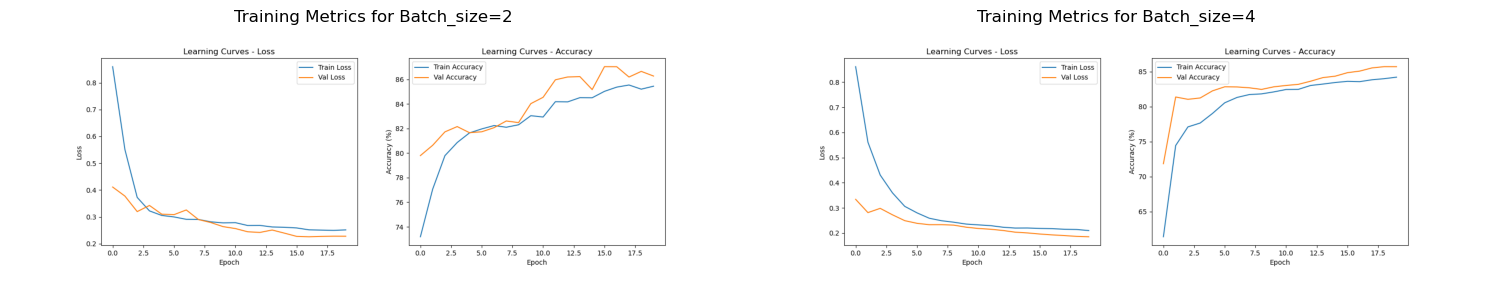

In [42]:
def visualize_training_curves(path_to_plot_1, path_to_plot_2):
    plt.figure(figsize=(15, 5))
    
    # Load and display the first plot
    img1 = mpimg.imread(path_to_plot_1)
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis('off')  
    plt.title('Training Metrics for Batch_size=2')

    # Load and display the second plot
    img2 = mpimg.imread(path_to_plot_2)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis('off')  
    plt.title('Training Metrics for Batch_size=4')
    
    plt.tight_layout()
    plt.show() 
plot_1_path = "../training/checkpoints/learning_curves_batch_size_2.png"
plot_2_path = "../training/checkpoints/learning_curves_batch_size_4.png"
visualize_training_curves(plot_1_path, plot_2_path)

It appears that indeed, the higher the batch size, the more stable the training process. However, emperical resutls showed that the performance of the model on the test set got worse with higher batch sizes (the generalizability got poorer). Hence, the final decision to use a batch size of 1, which is in line with what the authors of UNet used in their original paper

### Model Evaluation
The performance of the implemented Unet model was evaluated against the test set. Note that since the original dataset for the UNet paper was used, the test samples did not have the labels (masks). As such, the model was evaluated by predicting the test labels for the test samples and the results are subsequently visualized below

In [15]:
# Load and use the best model for predictions
def load_best_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path,  weights_only=True)
    model = UNet(
        retain_dim=True,
        out_sz=checkpoint['config']['out_size']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Load the best model
best_model = load_best_model('../training/checkpoints/final_model.pth')
best_model = best_model.to(trainer.device)
best_model.eval()

# test_data_transform
test_transform = DualTransform([
    ToTensor(),
    Normalize(mean=[mean], std=[std]) # mean and std from training data distribution
])

# Load test dataset
test_dataset = CellDataset(root_dir='../data/dataset', split="test", test_mode=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Directory to save predictions
output_dir = "../predicted_masks/cell_seg"
os.makedirs(output_dir, exist_ok=True)

for idx, (images, file_name,  _) in enumerate(test_loader):  # Dummy labels are ignored
    images = images.to(trainer.device)
    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
    # Save predicted masks
    # out = outputs.cpu().float()
    pred_mask = preds.cpu().float()
    save_path = os.path.join(output_dir, f"{file_name[0].split('.')[0]}.png")
    save_image(pred_mask, save_path)
    print(f"Saved predicted mask to {save_path}")
   

Saved predicted mask to ../predicted_masks/cell_seg\0.png
Saved predicted mask to ../predicted_masks/cell_seg\1.png
Saved predicted mask to ../predicted_masks/cell_seg\10.png
Saved predicted mask to ../predicted_masks/cell_seg\11.png
Saved predicted mask to ../predicted_masks/cell_seg\12.png
Saved predicted mask to ../predicted_masks/cell_seg\13.png
Saved predicted mask to ../predicted_masks/cell_seg\14.png
Saved predicted mask to ../predicted_masks/cell_seg\15.png
Saved predicted mask to ../predicted_masks/cell_seg\16.png
Saved predicted mask to ../predicted_masks/cell_seg\17.png
Saved predicted mask to ../predicted_masks/cell_seg\18.png
Saved predicted mask to ../predicted_masks/cell_seg\19.png
Saved predicted mask to ../predicted_masks/cell_seg\2.png
Saved predicted mask to ../predicted_masks/cell_seg\20.png
Saved predicted mask to ../predicted_masks/cell_seg\21.png
Saved predicted mask to ../predicted_masks/cell_seg\22.png
Saved predicted mask to ../predicted_masks/cell_seg\23.png


### Predicted Test Samples Visualization
Four test samples alongside their predicted masks are randomly sampled and visualized below

[Go to table of content](#Table-of-content:)

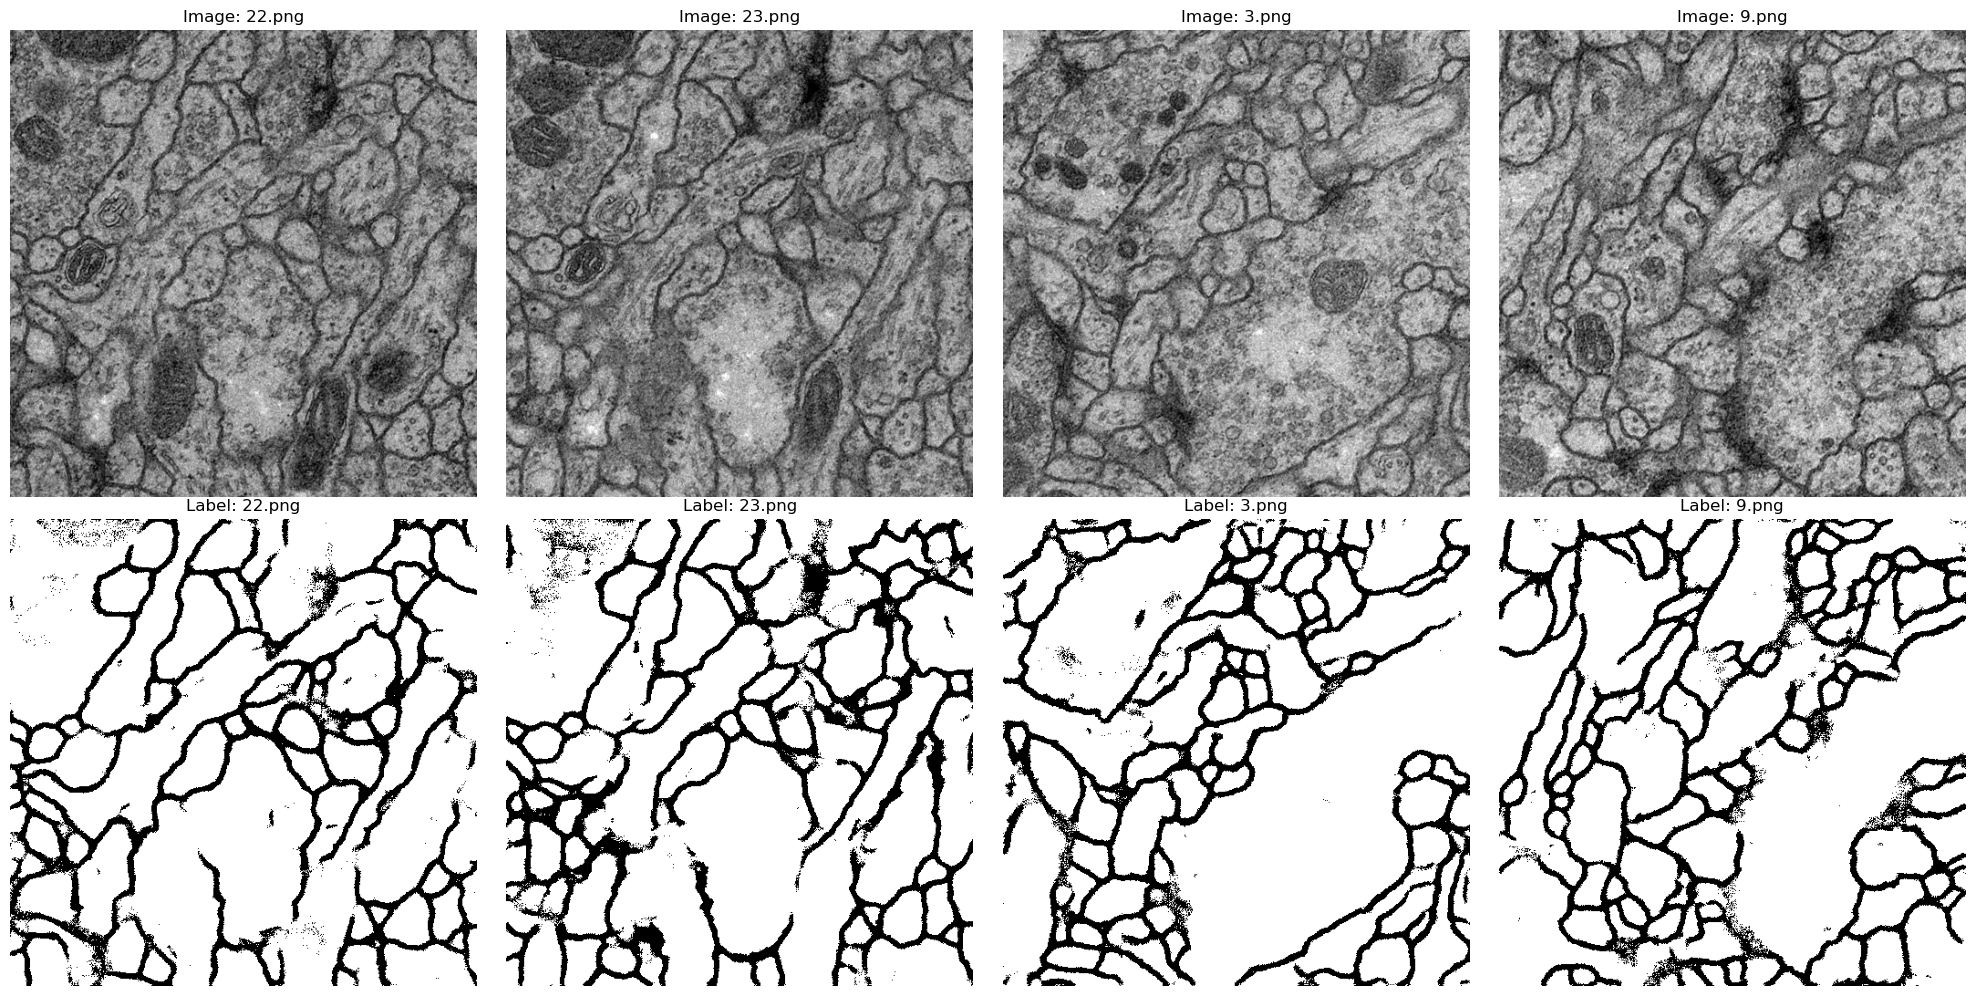

In [48]:
test_img_dir = os.path.join("../data", "dataset", 'test', 'imgs')
test_preds_dir = os.path.join("../predicted_masks", "cell_seg") 
visualize_data_samples(test_img_dir, test_preds_dir)

Indeed, the results above demonstrate that the model is able to correctly predict the masks for the test sets with some degree of noise. This makes sense since only 25 samples were used to train the model with 5 samples serving as validation set. With more hyper-parameter fine-tuning, the results could have gotten better!<br>

*Note, the masks for the test samples are not available so it is impossible to calculate the DICE coeff for the test set!*

## Part B:
### Extra work
#### Brain tumor segmentation
In this section, the UNet model is used for segmenting the [brain tumor dataset](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427) Comparatively, The brain tumor segmentation is a bit more challenging than the dataset used in [Part A](#Part-A:), since it deals with MRI data, where tumors may have irregular shapes and varying intensities, posing challenges in distinguishing tumor boundaries from normal tissue. 

[Click here to go back to table of content](#Table-of-content:)

In [1]:
import os
import sys
import argparse
import numpy as np
import cv2
import hdf5storage
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torchvision.utils import save_image

# Get the absolute path of the project root directory
project_root = os.path.abspath("..")

# Add the project root to the Python module search path
if project_root not in sys.path:
    sys.path.append(project_root) 

from data.dataset import get_dataloaders
from models.brain_tumor_trainer import Trainer as BrainTumorTrainer
from models.model import UNet


### Brain Tumor Data Loaders 
The brain tumor dataset is in MATLAB format. For this reason, it is first processed by converting to numpy and then normalized. The data is then split into train, val, test sets. For full implementation details, check the file `project_dir/data/dataset.py` and scroll to the `BrainTumorDataset` section.<br>
*It is also worth noting that, no data augumentation techniques were applied to this dataset since the size of the dataset was considerably large.*

In [ ]:
DATA_DIR = "../data/brain-tumor-dataset/data"
IMAGE_DIMENSION = 512
BATCH_SIZE = 2

# Get DataLoaders
train_loader, val_loader, test_loader = get_dataloaders(
    DATA_DIR, image_dimension=IMAGE_DIMENSION, batch_size=BATCH_SIZE, val_split=0.15, test_split=0.1
)

In [3]:
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 1150
Validation batches: 230
Test batches: 153


### Visualize data samples from the training set

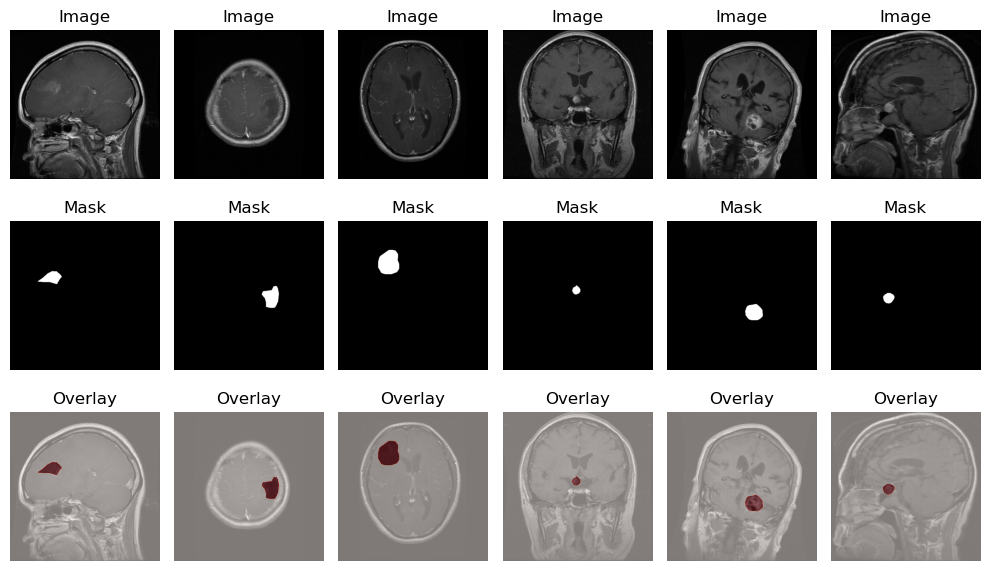

In [4]:
def visualize_samples(loader=train_loader, num_images=6):
    """
    Function to retrieve and visualize images and masks from a data loader.
    
    Parameters:
        loader (DataLoader): The PyTorch DataLoader containing the dataset.
        num_images (int): Number of images and masks to visualize.
    """
    
    # Collect images and masks from multiple batches if necessary
    images, masks = [], []
    data_iter = iter(loader)
    
    while len(images) < num_images:
        batch_images, batch_masks = next(data_iter)  # Get a batch
        images.extend(batch_images)
        masks.extend(batch_masks)
    
    # Convert to tensors and select the required number of images
    images = torch.stack(images[:num_images])
    masks = torch.stack(masks[:num_images])
    
    # Move data to CPU for visualization (if it's on GPU)
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    
    # Visualize the selected samples
    plt.figure(figsize=(10, 6))
    for i in range(num_images):
        # Original Image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i][0], cmap='gray')  # The [0] index removes the channel dimension
        plt.title("Image")
        plt.axis("off")

        # Corresponding Mask
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(masks[i][0], cmap='gray')  # The [0] index removes the channel dimension
        plt.title("Mask")
        plt.axis("off")

        # Overlay of Image and Mask
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(images[i][0], cmap='gray')
        plt.imshow(masks[i][0], alpha=0.5, cmap='Reds')  # Overlay mask in red
        plt.title("Overlay")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show() 

visualize_samples(train_loader, BATCH_SIZE)

As can be seen from the samples above, indeed, it appears that this dataset is much challenging to segment compared to the first dataset in [Part A](#Part-A:)

### Configuration
Just like before, a `Trainer` class containing methods for carrying out the training process was implemented. The trainer class is slightly different from the one used to train the model in Part A. Here, the trainer also takes a config object during initialization and uses the defined parameters for initializing the UNet model as well as carrying out the training process.<br>
*The most difficult parameters were the weights for the BCE and DICE coeff. It was very challenging to find the optimal values to achieve a descent, well-performing model.* <br>
[Click here to go back to the beginning of Part B](#Part-B:)

In [11]:
br_config = {
    # Model parameters
    'out_size': (512, 512),
    'encoder_channels': (1, 64, 128, 256, 512, 1024),
    'decoder_channels': (1024, 512, 256, 128, 64), 
    
    # Training parameters
    'batch_size': BATCH_SIZE,
    'learning_rate': 1e-4,
    'beta1': 0.9,
    'beta2': 0.999,
    'eps': 1e-8,
    'weight_decay': 1e-4,
    'start_epoch': 1,
    'end_epoch': 30,
    'dropout_rate': 0.5, 
    
    # Loss function weights - These parameters needed a lot of experimentation to find the best values
    'bce_weight': 0.55, 
    'dice_weight': 0.45
}

### Initialize Brain Tumor Trainer and Train model
Here we initialize the trainer class and pass the defined configuration object (dictionary) to it. <br>
*For full implementation details, refer to the file `project_dir/models/brain_tumor_trainer.py`*

In [12]:
# directory to save the weights and training output
save_dir = "../training/brain-tumor"
bt_trainer = BrainTumorTrainer(br_config, train_loader, val_loader, save_dir)

In [13]:
# We call the train method to carry out the training process
bt_trainer.train()

Validation Epoch 1: 100%|████████████████████████████████████████████████████████████| 230/230 [00:46<00:00,  4.97it/s]


Epoch 1: Train Loss=0.4395, Train Acc=97.04, Train Dice=0.2710 | Val Loss=0.3759, Val Acc=97.75, Val Dice=0.3763


Validation Epoch 2: 100%|████████████████████████████████████████████████████████████| 230/230 [00:46<00:00,  4.91it/s]


Epoch 2: Train Loss=0.3354, Train Acc=98.34, Train Dice=0.4297 | Val Loss=0.3224, Val Acc=98.30, Val Dice=0.4545


Validation Epoch 3: 100%|████████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.89it/s]


Epoch 3: Train Loss=0.3088, Train Acc=98.48, Train Dice=0.4772 | Val Loss=0.2933, Val Acc=98.47, Val Dice=0.5034


Validation Epoch 4: 100%|████████████████████████████████████████████████████████████| 230/230 [01:55<00:00,  2.00it/s]


Epoch 4: Train Loss=0.2867, Train Acc=98.57, Train Dice=0.5148 | Val Loss=0.2691, Val Acc=98.62, Val Dice=0.5412


Validation Epoch 5: 100%|████████████████████████████████████████████████████████████| 230/230 [00:46<00:00,  4.90it/s]


Epoch 5: Train Loss=0.2708, Train Acc=98.62, Train Dice=0.5425 | Val Loss=0.2513, Val Acc=98.72, Val Dice=0.5737


Validation Epoch 6: 100%|████████████████████████████████████████████████████████████| 230/230 [00:46<00:00,  4.99it/s]


Epoch 6: Train Loss=0.2554, Train Acc=98.68, Train Dice=0.5683 | Val Loss=0.2405, Val Acc=98.82, Val Dice=0.5941


Validation Epoch 7: 100%|████████████████████████████████████████████████████████████| 230/230 [00:45<00:00,  5.00it/s]


Epoch 7: Train Loss=0.2460, Train Acc=98.72, Train Dice=0.5849 | Val Loss=0.2436, Val Acc=98.72, Val Dice=0.5903


Validation Epoch 8: 100%|████████████████████████████████████████████████████████████| 230/230 [00:46<00:00,  4.99it/s]


Epoch 8: Train Loss=0.2341, Train Acc=98.78, Train Dice=0.6055 | Val Loss=0.2263, Val Acc=98.90, Val Dice=0.6122


Validation Epoch 9: 100%|████████████████████████████████████████████████████████████| 230/230 [00:46<00:00,  4.91it/s]


Epoch 9: Train Loss=0.2294, Train Acc=98.81, Train Dice=0.6127 | Val Loss=0.2111, Val Acc=98.92, Val Dice=0.6404


Validation Epoch 10: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.84it/s]


Epoch 10: Train Loss=0.2229, Train Acc=98.84, Train Dice=0.6245 | Val Loss=0.2152, Val Acc=98.94, Val Dice=0.6360


Validation Epoch 11: 100%|███████████████████████████████████████████████████████████| 230/230 [00:46<00:00,  4.90it/s]


Epoch 11: Train Loss=0.2181, Train Acc=98.88, Train Dice=0.6332 | Val Loss=0.2022, Val Acc=99.04, Val Dice=0.6528


Validation Epoch 12: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.88it/s]


Epoch 12: Train Loss=0.2154, Train Acc=98.85, Train Dice=0.6376 | Val Loss=0.2156, Val Acc=98.95, Val Dice=0.6347


Validation Epoch 13: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.89it/s]


Epoch 13: Train Loss=0.2100, Train Acc=98.90, Train Dice=0.6454 | Val Loss=0.1992, Val Acc=98.76, Val Dice=0.6671


Validation Epoch 14: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.85it/s]


Epoch 14: Train Loss=0.2062, Train Acc=98.92, Train Dice=0.6520 | Val Loss=0.2050, Val Acc=99.05, Val Dice=0.6494


Validation Epoch 15: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.80it/s]


Epoch 15: Train Loss=0.2041, Train Acc=98.93, Train Dice=0.6563 | Val Loss=0.1803, Val Acc=99.09, Val Dice=0.6948


Validation Epoch 16: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.88it/s]


Epoch 16: Train Loss=0.2000, Train Acc=98.95, Train Dice=0.6615 | Val Loss=0.1959, Val Acc=98.90, Val Dice=0.6720


Validation Epoch 17: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.80it/s]


Epoch 17: Train Loss=0.1939, Train Acc=98.98, Train Dice=0.6735 | Val Loss=0.1969, Val Acc=99.06, Val Dice=0.6679


Validation Epoch 18: 100%|███████████████████████████████████████████████████████████| 230/230 [00:48<00:00,  4.78it/s]


Epoch 18: Train Loss=0.1894, Train Acc=99.00, Train Dice=0.6819 | Val Loss=0.1861, Val Acc=99.11, Val Dice=0.6823


Validation Epoch 19: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.82it/s]


Epoch 19: Train Loss=0.1912, Train Acc=99.00, Train Dice=0.6773 | Val Loss=0.1846, Val Acc=99.11, Val Dice=0.6849


Validation Epoch 20: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.86it/s]


Epoch 20: Train Loss=0.1870, Train Acc=99.01, Train Dice=0.6853 | Val Loss=0.1825, Val Acc=99.08, Val Dice=0.6887


Validation Epoch 21: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.81it/s]


Epoch 21: Train Loss=0.1866, Train Acc=99.03, Train Dice=0.6852 | Val Loss=0.1796, Val Acc=99.15, Val Dice=0.6928


Validation Epoch 22: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.86it/s]


Epoch 22: Train Loss=0.1798, Train Acc=99.05, Train Dice=0.6974 | Val Loss=0.1822, Val Acc=99.13, Val Dice=0.6904


Validation Epoch 23: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.84it/s]


Epoch 23: Train Loss=0.1762, Train Acc=99.07, Train Dice=0.7032 | Val Loss=0.1655, Val Acc=99.14, Val Dice=0.7190


Validation Epoch 24: 100%|███████████████████████████████████████████████████████████| 230/230 [00:46<00:00,  4.90it/s]


Epoch 24: Train Loss=0.1776, Train Acc=99.06, Train Dice=0.7006 | Val Loss=0.1719, Val Acc=99.18, Val Dice=0.7047


Validation Epoch 25: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.89it/s]


Epoch 25: Train Loss=0.1771, Train Acc=99.06, Train Dice=0.7024 | Val Loss=0.1667, Val Acc=99.15, Val Dice=0.7168


Validation Epoch 26: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.80it/s]


Epoch 26: Train Loss=0.1693, Train Acc=99.10, Train Dice=0.7144 | Val Loss=0.1677, Val Acc=99.11, Val Dice=0.7153


Validation Epoch 27: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.86it/s]


Epoch 27: Train Loss=0.1720, Train Acc=99.08, Train Dice=0.7101 | Val Loss=0.1658, Val Acc=99.14, Val Dice=0.7172


Validation Epoch 28: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.88it/s]


Epoch 28: Train Loss=0.1640, Train Acc=99.13, Train Dice=0.7239 | Val Loss=0.1965, Val Acc=98.68, Val Dice=0.6742


Validation Epoch 29: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.84it/s]


Epoch 29: Train Loss=0.1683, Train Acc=99.11, Train Dice=0.7157 | Val Loss=0.1625, Val Acc=99.10, Val Dice=0.7241


Validation Epoch 30: 100%|███████████████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.89it/s]


Epoch 30: Train Loss=0.1634, Train Acc=99.15, Train Dice=0.7246 | Val Loss=0.1532, Val Acc=99.21, Val Dice=0.7399
Training complete. Best validation loss: 0.1532


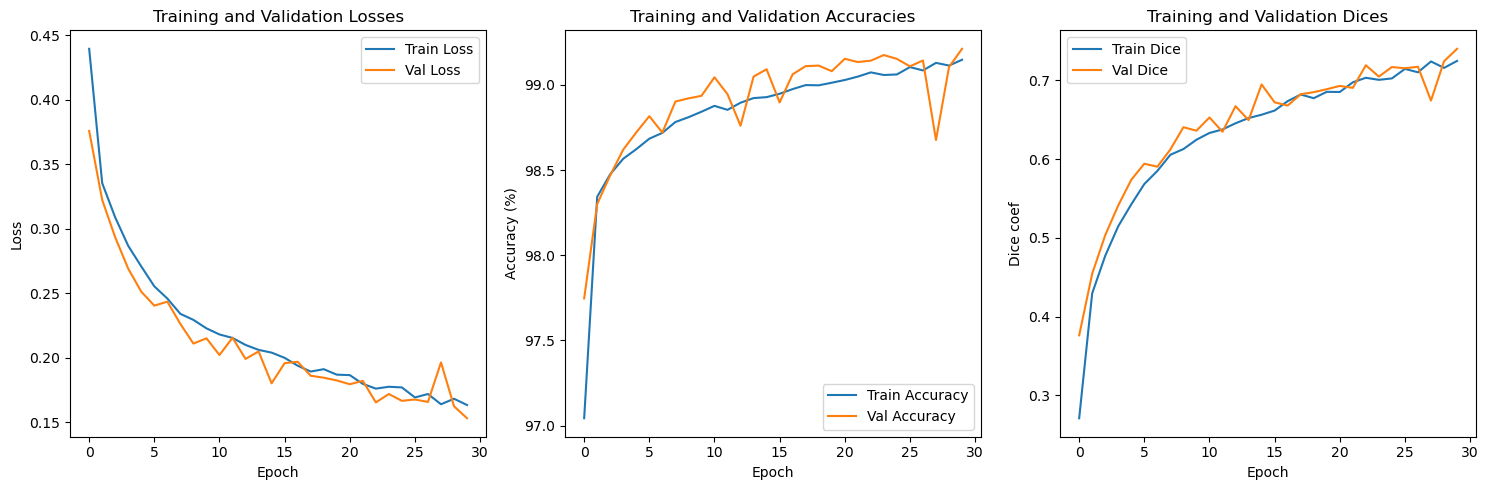

In [39]:
# Plot final metrics
def plot_bt_metrics(trainer):
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 3, 1)
    plt.plot(trainer.train_losses, label='Train Loss')
    plt.plot(trainer.val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    
    # Plot accuracies
    plt.subplot(1, 3, 2)
    plt.plot(trainer.train_accuracies, label='Train Accuracy')
    plt.plot(trainer.val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracies') 

    # Plot dices
    plt.subplot(1, 3, 3)
    plt.plot(trainer.train_dices, label='Train Dice')
    plt.plot(trainer.val_dices, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice coef')
    plt.legend()
    plt.title('Training and Validation Dices') 

    
    plt.tight_layout()
    plt.show()
    
# Plot the training metrics
plot_bt_metrics(bt_trainer)

From the training curves above, It can be observed that the training process was quite smooth despite the few spikes that occured. Of course, this is a relatively difficult task (for the UNet), and hence the achieved training result is impressive. The validation loss is lower than the train loss on average, which is quite impressive. Same with the Validation DICE and validation Accuracy. 

*Here, accuracy is not a good perforrmance measure since there are more black pixels than white pixels in the true labels (masks). In other words, there is a class imbalance.* <br> The best way to assess the model's performance would be to calculate the DICE coefficient score over all the test set. But before that, let's run inference on the test set 

### Brain-Tumor Model Performance Evaluation

In [15]:
# Load and use the best model for predictions
def load_best_model(checkpoint_path, device, out_size=(512, 512)):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    model = UNet(
        retain_dim=True,
        out_sz=out_size
    ).to(device)
    
    model.load_state_dict(checkpoint)
    
    with torch.no_grad():  # Ensures no unnecessary computation graph creation
        model.eval()

    return model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "../training/brain-tumor/overall_best_model.pth"
out_size = (512, 512)

# Load model without printing architecture
best_model = load_best_model(checkpoint_path, device, out_size)

### Inference on the test set

In [17]:
# Directory to save predictions
output_dir = "../predicted_masks/brain-tumor"
# Directory to save the masks (since the data is in .mat format) - we need the true masks to compare them to the predicted masks
mask_gold_dir = "../data/brain-tumor-dataset/masks"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(mask_gold_dir, exist_ok=True)


best_model.eval()

# Iterate over test_loader
with torch.no_grad(): 
    for idx, (images, masks) in enumerate(test_loader):  
        images = images.to(device)
        outputs = best_model(images)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().float()  # Convert logits to binary masks and move to CPU 
        
        # Save each predicted mask in the batch
        for i, mask in enumerate(preds): 
            save_path = os.path.join(output_dir, f"{idx}_{i}.png")
            save_image(mask, save_path)
        
        # Save each ground truth (gold) mask in the batch
        masks = masks.cpu().float()  
        for i, mask in enumerate(masks):
            save_path = os.path.join(mask_gold_dir, f"{idx}_{i}.png")
            save_image(mask, save_path)

print("Done: All predicted and ground truth masks saved.")

Done: All predicted and ground truth masks saved.


### Performance Evaluation
Let's compare the perfomance of the model by first visually inspecting some random predicted masks against the true labels (masks)

[Go to beginning of Part B](#Part-B:)

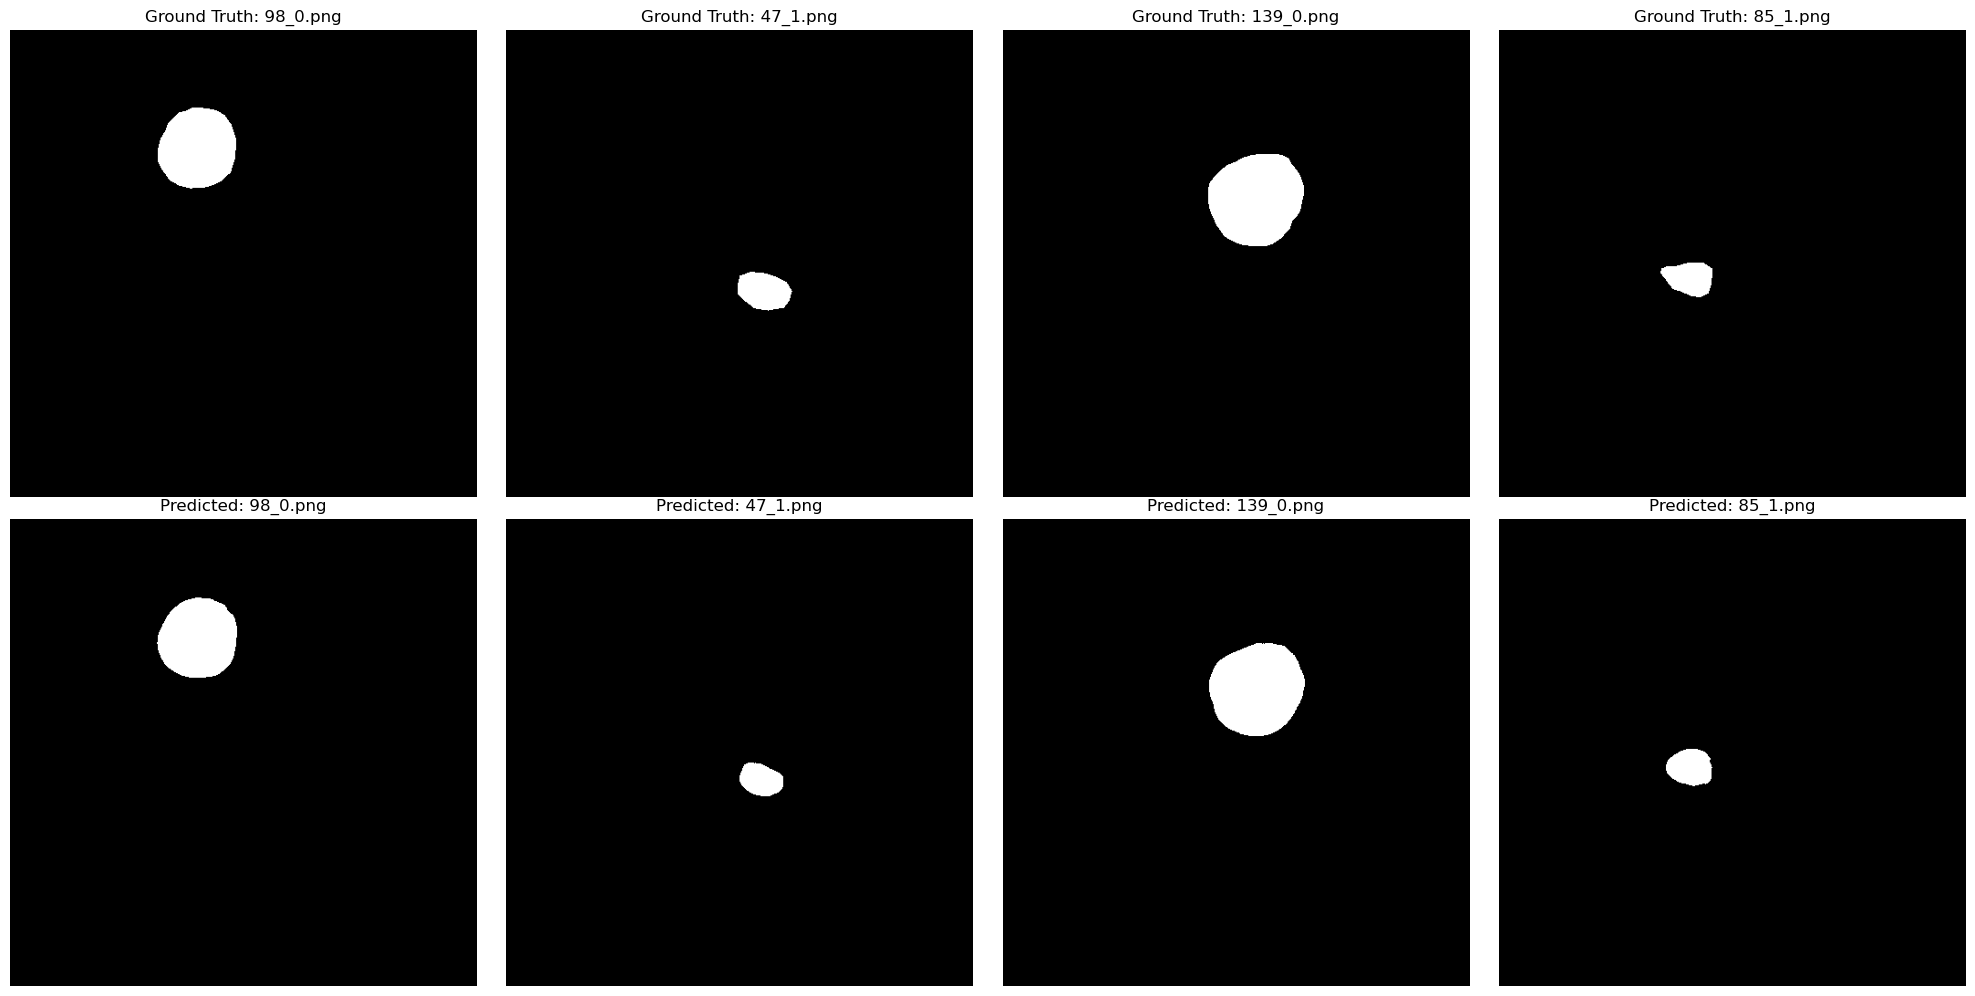

In [38]:
test_img_masks_dir = "../data/brain-tumor-dataset/masks"
predicted_masks_dir = "../predicted_masks/brain-tumor"

def visualize_test_predicted_masks(test_masks_dir=test_img_masks_dir, pred_masks_dir=predicted_masks_dir):
    # Get filenames of true masks
    mask_fns = os.listdir(test_masks_dir)
    
    # Ensure there are at least 4 images to sample
    if len(mask_fns) < 4:
        print("Not enough images in the directory to sample.")
        return
    
    # Create a grid for 4 images and their predictions (2 rows, 4 columns)
    f, axarr = plt.subplots(2, 4, figsize=(20, 10))
    
    # Randomly sample 4 indices
    indices = random.sample(range(len(mask_fns)), 4)
    
    for i, index in enumerate(indices):
        # Get the corresponding filenames
        mask_fn = mask_fns[index]
        pred_fn = mask_fn  # Prediction file should have the same name
    
        # Construct full paths to the ground truth and predicted masks
        mask_path = os.path.join(test_masks_dir, mask_fn)
        pred_path = os.path.join(pred_masks_dir, pred_fn)
    
        # Read the ground truth and predicted masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
        
        # Check if images are successfully loaded
        if mask is None or pred is None:
            print(f"Could not load one of the images: {mask_fn}")
            continue
    
        # Display the ground truth mask
        axarr[0, i].imshow(mask, cmap='gray')
        axarr[0, i].axis('off')
        axarr[0, i].set_title(f"Ground Truth: {mask_fn}")
    
        # Display the predicted mask
        axarr[1, i].imshow(pred, cmap='gray')
        axarr[1, i].axis('off')
        axarr[1, i].set_title(f"Predicted: {pred_fn}")
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show() 
visualize_test_predicted_masks(test_img_masks_dir, predicted_masks_dir)

From the results above, it is not difficult to observe that the model has done impressively well on the test set. The predicted masks closely match the true masks. To measure the model's performance on the entire test set, we could calculate the DICE coefficient score over the entire test set, to help us gain an idea of how well the model performed. Let's carry out that next!

### Test set DICE calculation

[Go to beginning of Part B](#Part-B:)

In [54]:
def compute_dice_coefficient(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Compute the Dice coefficient between two binary masks.
    
    Parameters:
        mask1 (np.ndarray): First binary mask
        mask2 (np.ndarray): Second binary mask
    
    Returns:
        float: Dice coefficient between 0 and 1
    
    Raises:
        ValueError: If masks have different shapes or aren't binary
    """
    # Ensure masks have same shape
    if mask1.shape != mask2.shape:
        raise ValueError(f"Masks must have same shape. Got {mask1.shape} and {mask2.shape}")
    
    # Ensure masks are binary
    mask1_binary = np.where(mask1 > 127, 1, 0).astype(np.uint8)
    mask2_binary = np.where(mask2 > 127, 1, 0).astype(np.uint8)
    
    intersection = np.sum(mask1_binary * mask2_binary)
    sum_masks = np.sum(mask1_binary) + np.sum(mask2_binary)
    
    return (2. * intersection) / sum_masks if sum_masks > 0 else 1.0

def compute_overall_dice(test_masks_dir: str, pred_masks_dir: str, file_extension: str = '.png'):
    """
    Compute the overall mean DICE coefficient for the test set.
    
    Parameters:
        test_masks_dir (str): Directory containing ground truth masks
        pred_masks_dir (str): Directory containing predicted masks
        file_extension (str): Expected file extension for masks
    
    Returns:
        Tuple containing:
        - float: Mean DICE coefficient across the test set
        - List[Tuple[str, float]]: List of (filename, dice_score) pairs
        - Optional[str]: Error message if any issues occurred
    """
    if not os.path.exists(test_masks_dir) or not os.path.exists(pred_masks_dir):
        return 0.0, [], f"One or both directories don't exist: {test_masks_dir}, {pred_masks_dir}"
    
    dice_scores = []
    errors = []
    
    # Get list of test files with specific extension
    test_files = sorted([f for f in os.listdir(test_masks_dir) if f.endswith(file_extension)])
    
    if not test_files:
        return 0.0, [], f"No files with extension {file_extension} found in {test_masks_dir}"
    
    for file_name in test_files:
        test_mask_path = os.path.join(test_masks_dir, file_name)
        pred_mask_path = os.path.join(pred_masks_dir, file_name)
        
        # Skip if predicted mask doesn't exist
        if not os.path.exists(pred_mask_path):
            errors.append(f"Predicted mask not found: {file_name}")
            continue
            
        try:
            # Load masks
            pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)
            gt_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
            
            if pred_mask is None or gt_mask is None:
                errors.append(f"Failed to load masks for {file_name}")
                continue
                
            # Compute DICE coefficient
            dice_score = compute_dice_coefficient(pred_mask, gt_mask)
            dice_scores.append((file_name, dice_score))
            
        except Exception as e:
            errors.append(f"Error processing {file_name}: {str(e)}")
            continue
    
    if not dice_scores:
        return 0.0, [], "No valid mask pairs were processed"
        
    # Compute statistics
    scores_only = [score for _, score in dice_scores]
    overall_dice = np.mean(scores_only)
    
    # Return results and any error messages
    error_message = "\n".join(errors) if errors else None
    return overall_dice, dice_scores, error_message
    
pred_masks_dir = "../predicted_masks/brain-tumor"
mask_gold_dir = "../data/brain-tumor-dataset/masks"

over_all_dice_score, _, _ = compute_overall_dice(mask_gold_dir, pred_masks_dir)
print(f"Overall DICE Coefficient score on test set: {over_all_dice_score:.2f}")

Overall DICE Coefficient score on test set: 0.68


We have achieved a DICE Coef score of 0.68 on the test set, which is generally good for the task at hand. The training metrics curves reveal that the model could have been further trained to improve its performance. It can be observed that even at 30 epochs, the training had not converged and therefore the model could have been trained for more epochs. However, this process was time-consuming (took about 8 hours to complete for 30 epochs) and hence, the decision to not train it further. In addition, it can be seen that the model did not overfit: it achieved the highest DICE score of 0.73 on the validation set, while on the test set, it achieved a score of 0.68, which is close enough. Almost about 70% of the predicted masks overlap with the true masks. 


### Conclusion 
In conclusion, two different dataset were tested on the UNet model implemented and the results were quite impressive. Some general notes include:
- Using batchNorm and Dropout layers in the UNet model implementation
- Custom Loss function
- Custom dataclass each for the two datasets used in this work
- Elastic deformation and Rigid transformation data augumentation techniques
- Modular approach to enable reusability of the UNet model for different tasks without altering the code
- Great results achieved on both the [Neuronal Cell Segmentation](#Part-A:) and [Brain Tumor Segmentation](#Part-B:) tasks

The UNet model is quite great in segmentation tasks with minimal hyper-parameter tuning.

*Thank you for taking your time to review this work!*

[Click here to back to the table of content](#Table-of-content:)

